<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [336]:
# librerias

import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem, beta

In [337]:
# datos

df=pd.read_csv('../6.4_lab-AB-Testing/data/cookie_cats.csv')

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [338]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [339]:
pd.crosstab(df.version, df.retention_1)


retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [340]:
pd.crosstab(df.version, df.retention_7)


retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [341]:
cats_30 = df[df.version == 'gate_30']

cats_40 = df[df.version == 'gate_40']

In [342]:
# muestreo

control = cats_30

tratamiento = cats_40

ab_test = pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,1066,gate_30,0,False,False
3,2101,gate_30,0,False,False
4,2179,gate_30,39,True,False


# testeo para retention_1

In [343]:
tasas_conversion=ab_test.groupby('version')['retention_1']  # agrupo por grupo



std=lambda x: np.std(x, ddof=0)    # std
error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))



tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}')

,conversion_rate,std,std_error
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.442,0.497,0.002


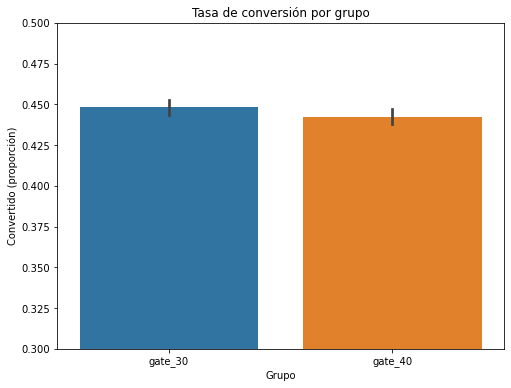

In [344]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_1'])

plt.ylim(0.3, 0.5 )
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [345]:


control_res=ab_test[ab_test.version=='gate_30']['retention_1']

trat_res=ab_test[ab_test.version=='gate_40']['retention_1']

In [346]:
observaciones = [control_res.count(), trat_res.count()]

conversiones=[control_res.sum(), trat_res.sum()]  # conversiones por grupo

z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones)


# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, 
                                                                            nobs=observaciones,
                                                                            alpha=0.05)

In [347]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 1.78
p-valor: 0.074
intervalo conf 95% para grupo control: [0.444, 0.453]
intervalo conf 95% para grupo tratamiento: [0.438, 0.447]


In [348]:
tasas_conversion

,conversion_rate,std,std_error
version,,,
gate_30,0.448188,0.497308,0.002352
gate_40,0.442283,0.496658,0.002329


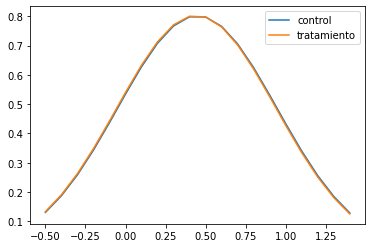

In [349]:
x=[i*.1 for i in range(-5, 15)]  

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

# testeo para retention_7


In [350]:
tasas_conversion=ab_test.groupby('version')['retention_7']  # agrupo por grupo



std=lambda x: np.std(x, ddof=0)    # std
error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))



tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}')


,conversion_rate,std,std_error
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


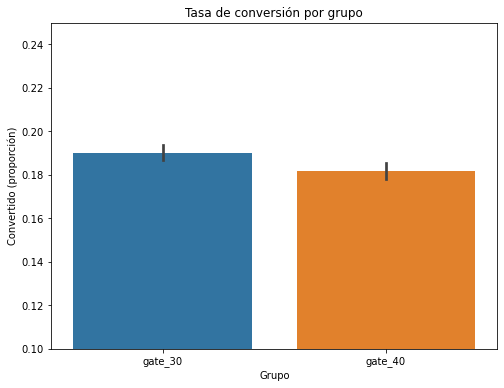

In [351]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_7'])

plt.ylim(0.1, 0.25 )
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [352]:

control_res=ab_test[ab_test.version=='gate_30']['retention_7']

trat_res=ab_test[ab_test.version=='gate_40']['retention_7']

In [353]:
observaciones = [control_res.count(), trat_res.count()]

conversiones=[control_res.sum(), trat_res.sum()]  # conversiones por grupo

z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones)


# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, 
                                                                            nobs=observaciones,
                                                                            alpha=0.05)

In [354]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 3.16
p-valor: 0.002
intervalo conf 95% para grupo control: [0.187, 0.194]
intervalo conf 95% para grupo tratamiento: [0.178, 0.186]


In [355]:
tasas_conversion

,conversion_rate,std,std_error
version,,,
gate_30,0.190201,0.392460,0.001856
gate_40,0.182000,0.385845,0.001809


In [356]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.

'''
    La conclusión es que en la retención a 1 día el pvalue es 0.074, por lo que se acercaría a la H0 por poco
    y mirando los intervalos de confiqanza varian muy poco por lo que nos quedamos con H0.
    
    En la pvalue de retención a 7 días que sería de un 0,002 se ve claramente que deberíamos coger la H1 por 
    lo que deberíamos cambiar a nivel 40 pero podemos ver en los intervalos de confianza que no variaría mucho por
    1o que igual no nos merecería la pena cambiar a H1.
    
    Por tanto a 1 día nos quedaremos con H0 y a 7 días según los intervalos de confianza igual no nos merece cambiar
    a H1 y es mejor quedarnos con H0. 
    
                                                                    '''

'\n    La conclusión es que en la retención a 1 día el pvalue es 0.074, por lo que se acercaría a la H0 por poco\n    y mirando los intervalos de confiqanza varian muy poco por lo que nos quedamos con H0.\n    \n    En la pvalue de retención a 7 días que sería de un 0,002 se ve claramente que deberíamos coger la H1 por \n    lo que deberíamos cambiar a nivel 40 pero podemos ver en los intervalos de confianza que no variaría mucho por\n    1o que igual no nos merecería la pena cambiar a H1.\n    \n    Por tanto a 1 día nos quedaremos con H0 y a 7 días según los intervalos de confianza igual no nos merece cambiar\n    a H1 y es mejor quedarnos con H0. \n    \n                                                                    '

# Bayesiano

In [357]:
# 1 día

In [358]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [359]:
aux = df[(df.version == 'gate_30')&(df.retention_1==True)]
aux = aux.groupby('version').retention_1.sum()
aux[0]

aux2 = df[(df.version == 'gate_40')&(df.retention_1==True)]
aux2 = aux2.groupby('version').retention_1.sum()
aux2[0]

20119

In [360]:

imps_ctrl, convs_ctrl = df[df.version == 'gate_30'].count()[0], aux[0]   # entrar, comprar
imps_test, convs_test= df[df.version == 'gate_40'].count()[0], aux2[0]


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'TASAS: Control={CR_ctrl}, Test={CR_test}'

'TASAS: Control=0.4481879194630872, Test=0.44228274967574577'

In [361]:
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)

In [362]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [363]:
x=np.linspace(0.43, 0.46, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

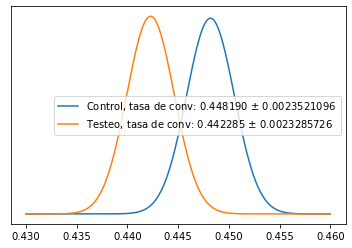

In [364]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [365]:
salto=(beta_test.mean() - beta_control.mean())/beta_control.mean()

salto

-0.013175098158249857

In [366]:
from mpmath import betainc 

In [367]:
beta.cdf(0.445, a_T, b_T)

0.8781293616836622

In [368]:
prob=beta.cdf(0.445, a_T, b_T) 

prob

0.8781293616836622

In [369]:

'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test aumenta la tasa de conversion en un -1.32%, con una probabilidad del 87.81%'

In [370]:
# 7 días

In [371]:
aux3 = df[(df.version == 'gate_30')&(df.retention_7==True)]
aux3 = aux3.groupby('version').retention_7.sum()
aux3[0]

aux4 = df[(df.version == 'gate_40')&(df.retention_7==True)]
aux4 = aux4.groupby('version').retention_7.sum()
aux4[0]

8279

In [372]:

imps_ctrl, convs_ctrl = df[df.version == 'gate_30'].count()[0], aux3[0]   # entrar, comprar
imps_test, convs_test= df[df.version == 'gate_40'].count()[0], aux4[0]


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'TASAS: Control={CR_ctrl}, Test={CR_test}'

'TASAS: Control=0.19020134228187918, Test=0.18200004396667327'

In [373]:
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_control7=beta(a_C, b_C)
beta_test7=beta(a_T, b_T)

In [374]:
beta_control7.mean(), beta_test7.mean()

(0.19021520289919913, 0.18201402475214878)

In [375]:
x=np.linspace(0.175, 0.20, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

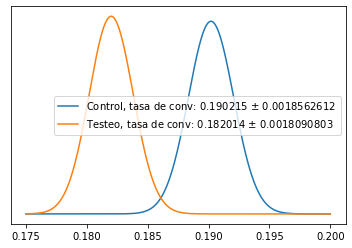

In [376]:
plot([beta_control7, beta_test7], ['Control', 'Testeo'])

In [381]:
salto=(beta_test7.mean() - beta_control7.mean())/beta_control7.mean()

salto

-0.04311526114658881

In [382]:
beta.cdf(0.186, a_T, b_T)

0.9858653005312228

In [383]:
prob=beta.cdf(0.186, a_T, b_T) 

prob

0.9858653005312228

In [384]:

'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test aumenta la tasa de conversion en un -4.31%, con una probabilidad del 98.59%'